# Ptychographic Reconstruction with gPIE

In this demo, we illustrate how **gPIE** can model and solve a 2D ptychographic imaging problem
using Expectation Propagation.

We assume that the *probe* is known and focus on reconstructing the *object* from measured diffraction patterns.


### 1. Problem Definition

Ptychography is a scanning diffraction imaging technique that measures
diffraction intensities as a localized probe is moved across an extended object.

In the Fraunhofer setting, each diffraction frame corresponds to the magnitude of the Fourier transform:

$$
A_i(k) = |\mathcal{F}\{ P(r) \cdot O(r - r_i) \}| + \text{noise},
$$

where $P(r)$ is the probe, $O(r)$ is the object, $r_i$ are the scan positions, and $\mathcal{F}$ is the 2D Fourier transform.

The discretized model is obtained as 

$$
\mathbf{A}_i = |\mathrm{F}\{ \mathbf{P} \odot \mathrm{S}^{(i)} \mathbf{O} \}| + \text{noise},
$$

Here, $\mathbf{O} \in \mathbb{C}^N$ and $\mathbf{P} \in \mathbb{C}^M $ are discretized object and probe function, $\mathrm{S}^{(i)} \in \{0,1\}^{M \times N}$ is the subsampling operator, and $\mathrm{F}$ is the 2D-DFT.  

Our goal is to retrieve the object $\mathbf{O}$ from the probe $\mathbf{P}$, the subsampling operators $\mathrm{S}^{(i)}\ (i = 1,2,\cdots, J)$, and the observations $\mathbf{A}_i \ (i = 1,2,\cdots, J)$.

### 2. Forward Simulation using `gpie.imaging.ptychography`

gPIE provides a **minimal set of utilities** for forward simulating ptychographic diffraction data through the `gpie.imaging.ptychography` module.  
The `PtychographyDataset` class manages all components of a ptychographic experiment: the object, probe, and diffraction data.
Its method `simulate_diffraction()` performs the following steps internally:

1. **Scan position generation** — generate a sequence of real-space scan coordinates $ r_i $ (e.g., Fermat spiral or raster, optionally with jitter).

2. **exit-wave synthesis** — construct the illuminated exit wave at each position as $ \mathbf{P} \odot \mathbf{O}_i $, using the known probe $ \mathbf{P} $ and the corresponding portion of the object $ \mathbf{O} $.

3. **Diffraction computation** — apply a 2D FFT to each exit wave, take the amplitude, and add Gaussian noise to obtain $ \mathbf{A}_i $.

The resulting frames and metadata are stored in the dataset as `DiffractionData`.


In the example below, we create a synthetic dataset using a known probe and a sample object illuminated at multiple scan positions.  
The generated dataset will later be used for EP-based reconstruction.


In [1]:
#imports
import numpy as np

from gpie.imaging.ptychography.data.dataset import PtychographyDataset
from gpie.imaging.ptychography.simulator.probe import generate_probe
from gpie.imaging.ptychography.simulator.scan import generate_fermat_spiral_positions

# load sample image from sk-image library
import os
import sys
EXAMPLES_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, EXAMPLES_DIR)

from io_utils import load_sample_image

In [2]:
# Generate synthetic object and probe

# --- Object (amplitude × phase) ---
obj_shape = (256, 256)
amp = load_sample_image("moon", shape=obj_shape)
phase = load_sample_image("coins", shape=obj_shape)
obj = amp * np.exp(1j * phase)

# --- Probe ---
pixel_size = 0.1  # µm per pixel
prb = generate_probe(
    shape=(128, 128),
    pixel_size=pixel_size,
    aperture_radius=2.0,
    smooth_edge_sigma=0.05,
)

In [3]:
# initialize ptychography dataset
noise = 1e-4
dataset = PtychographyDataset()
dataset.set_pixel_size(pixel_size)
dataset.set_object(obj)
dataset.set_probe(prb)

# generate scan positions and simulate diffraction

scan_gen = generate_fermat_spiral_positions(step_um=1.0)
dataset.simulate_diffraction(scan_gen, max_num_points=40, noise=noise)

print(f"Generated {dataset.size} diffraction patterns.")

Generated 40 diffraction patterns.


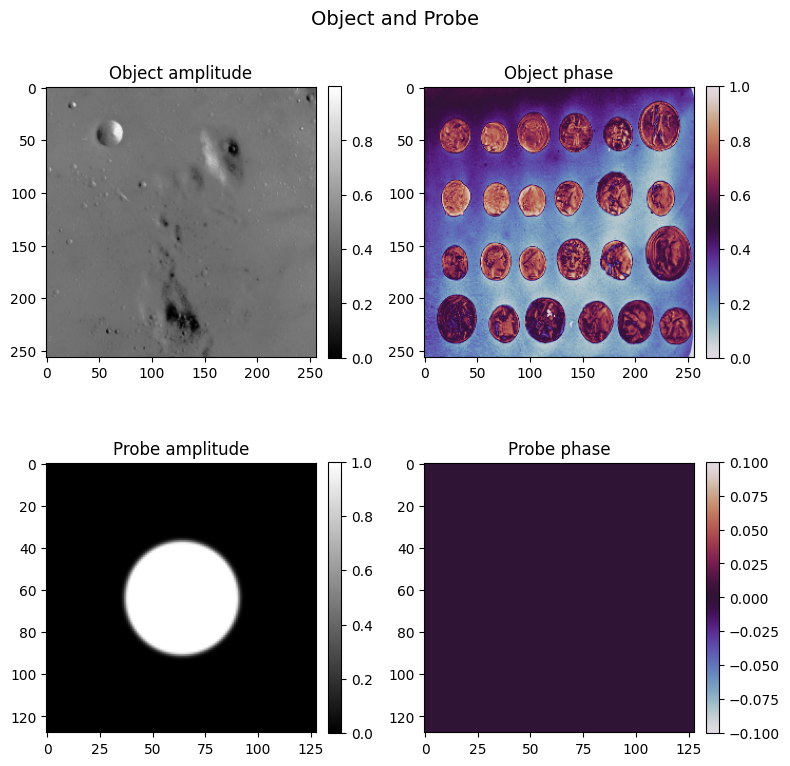

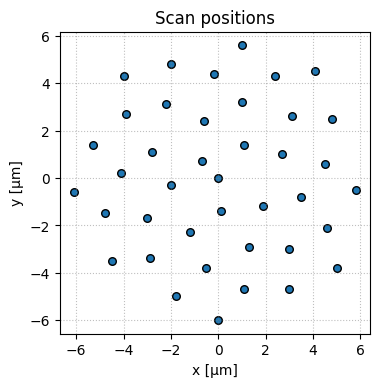

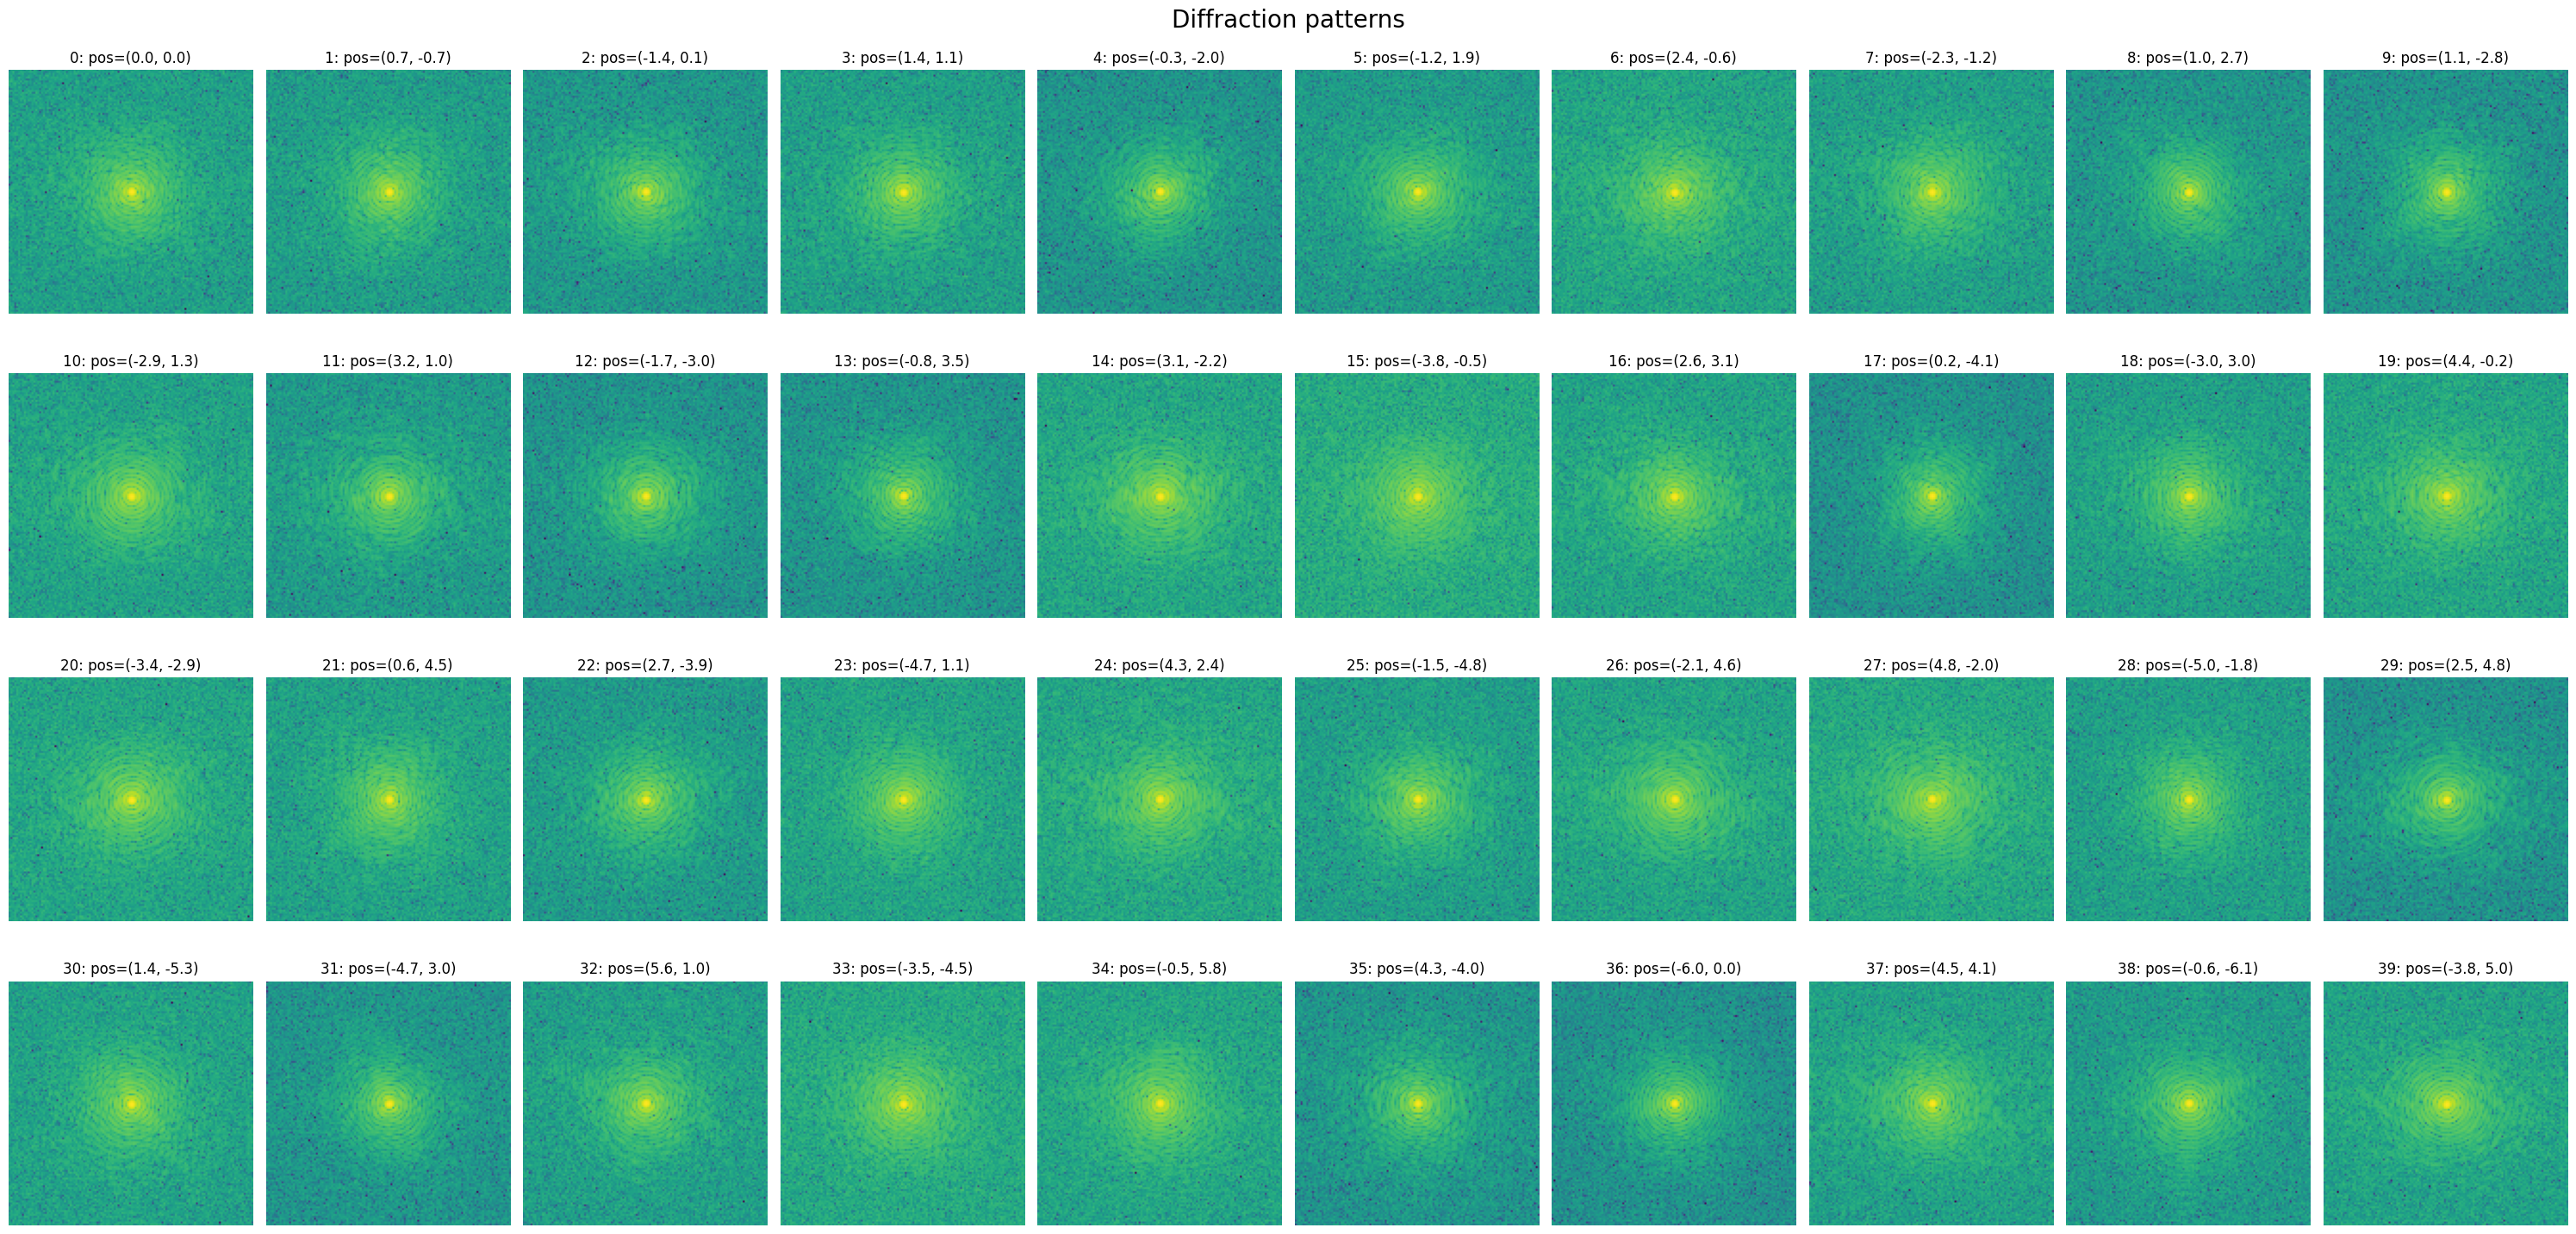

In [4]:
#visualization

# --- Object & Probe ---
fig1 = dataset.show_object_and_probe()

# --- Scan positions ---
fig2 = dataset.show_scan_positions()

# --- Diffraction patterns ---
fig3 = dataset.show_diffraction_patterns(ncols=10)


### 3. Defining the probabilistic model

The following model describes the generative process of ptychography in a probabilistic factor-graph.


In [5]:
from gpie import model, replicate, fft2, AmplitudeMeasurement, GaussianPrior
from typing import Tuple, List

@model
def ptychography_graph_known_probe(
    obj_shape,
    prb,                     
    indices,
    noise: float,
    dtype=np.complex64,
    damping: float = 0.3,
):
    """Ptychography graph with known probe."""
    obj = ~GaussianPrior(event_shape=obj_shape, label="object", dtype=dtype)
    patches = obj.extract_patches(indices)
    exit_waves = prb * patches  
    AmplitudeMeasurement(var=noise, label="meas", damping=damping) << fft2(exit_waves)
    return

### 4. Running Expectation Propagation (EP)

We now build the graph, and perform iterative EP updates.

In [6]:
from gpie.core.rng_utils import get_rng

# Prepare indices and initialize graph
graph = ptychography_graph_known_probe(
    obj_shape=obj_shape,
    prb = prb,
    indices=[d.indices for d in dataset],
    noise=noise
)

# feed the measurement node with observed data
meas_node = graph.get_factor("meas")
diffs = [d.diffraction for d in dataset]
meas_node.set_observed(np.stack(diffs))

In [7]:
graph.set_init_rng(get_rng(100))
graph.run(n_iter=100)

### 5. Visualizing the reconstruction

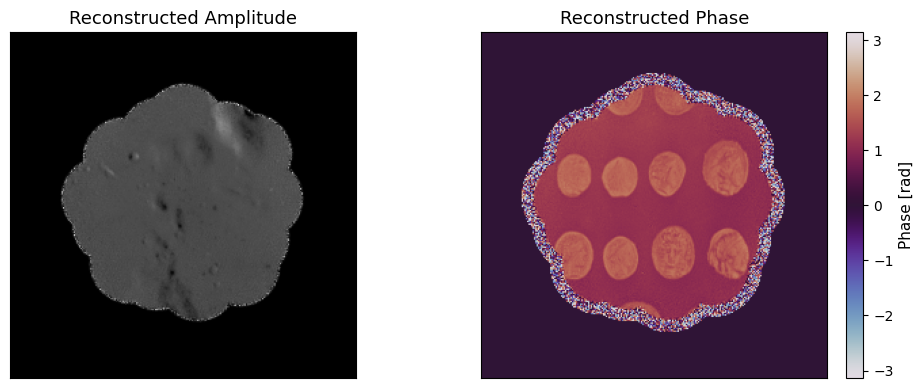

In [8]:
from matplotlib import pyplot as plt
import numpy as np

# Retrieve reconstructed object
recon = graph.get_wave("object").compute_belief().data[0]
amp = np.abs(recon)
phase = np.angle(recon)

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
titles = ["Reconstructed Amplitude", "Reconstructed Phase"]
images = [
    axes[0].imshow(amp, cmap="gray"),
    axes[1].imshow(phase, cmap="twilight", vmin=-np.pi, vmax=np.pi),
]

for ax, title in zip(axes, titles):
    ax.set_title(title, fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")

# Add colorbar only to phase
cbar = fig.colorbar(images[1], ax=axes[1], fraction=0.046, pad=0.04)
cbar.set_label("Phase [rad]", fontsize=11)

plt.tight_layout()
plt.show()
